<a href="https://colab.research.google.com/github/Taiba528/My-Python-World/blob/master/Ham_SpamCLassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#the goal of this exercise is to understand how to build an SMS spam detection model. We will build a binary classification model to detect whether a text message is spam or not.

In [1]:
#import necessary packages for analysis
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sklearn
import pickle
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve

In [2]:
# load dataset
from google.colab import files
uploaded = files.upload()

Saving SMS-Messages2.csv to SMS-Messages2.csv


In [3]:
#read file
df = pd.read_csv("SMS-Messages2.csv")
df.head()

,Message,Class_Label
0,'Go until jurong point,ham
1,'Ok lar... Joking wif u oni...',ham
2,'Free entry in 2 a wkly comp to win FA Cup fin...,spam
3,'U dun say so early hor... U c already then sa...,ham
4,'Nah I don\'t think he goes to usf,ham


# Data understanding :Explore the dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0    Message     200 non-null    object
 1   Class_Label  200 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


data set contains only two Columns  with messages & labels assigned with it without any missing value.

#Plot the data for visualization

In [5]:
df.groupby(['Class_Label']).count()

,Message
Class_Label,
ham,167
spam,33


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of ham and spam messages')

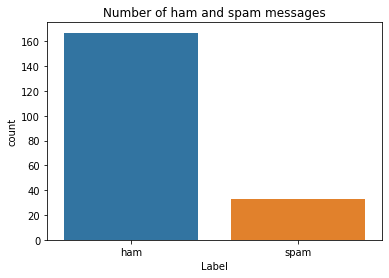

In [6]:
#Visualize the number of ham and spam messages
sns.countplot(df['Class_Label'])
plt.xlabel('Label')
plt.title('Number of ham and spam messages')



In [7]:
plot_size = plt.rcParams["figure.figsize"] 
plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size

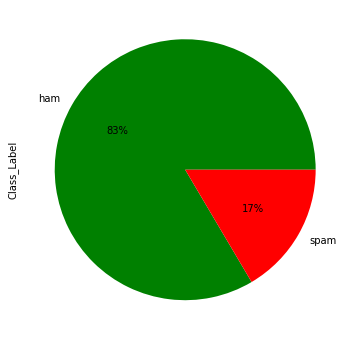

In [8]:
df.Class_Label.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["green","red"])

### out of 200 messages 167 which is 83% in total are ham messages while 17% are spam .

### From  bar graph &Pie-chart I understand that only 17% tweets spam,while 83% are ham.


In [9]:
#Rename columns
df=df.rename(columns={' Message':'Message','Class_Label':'label'})
df.columns

Index(['Message', 'label'], dtype='object')

#WordClouds- to see which words are common in SPAM and NOT SPAM mesaages


(-0.5, 399.5, 199.5, -0.5)

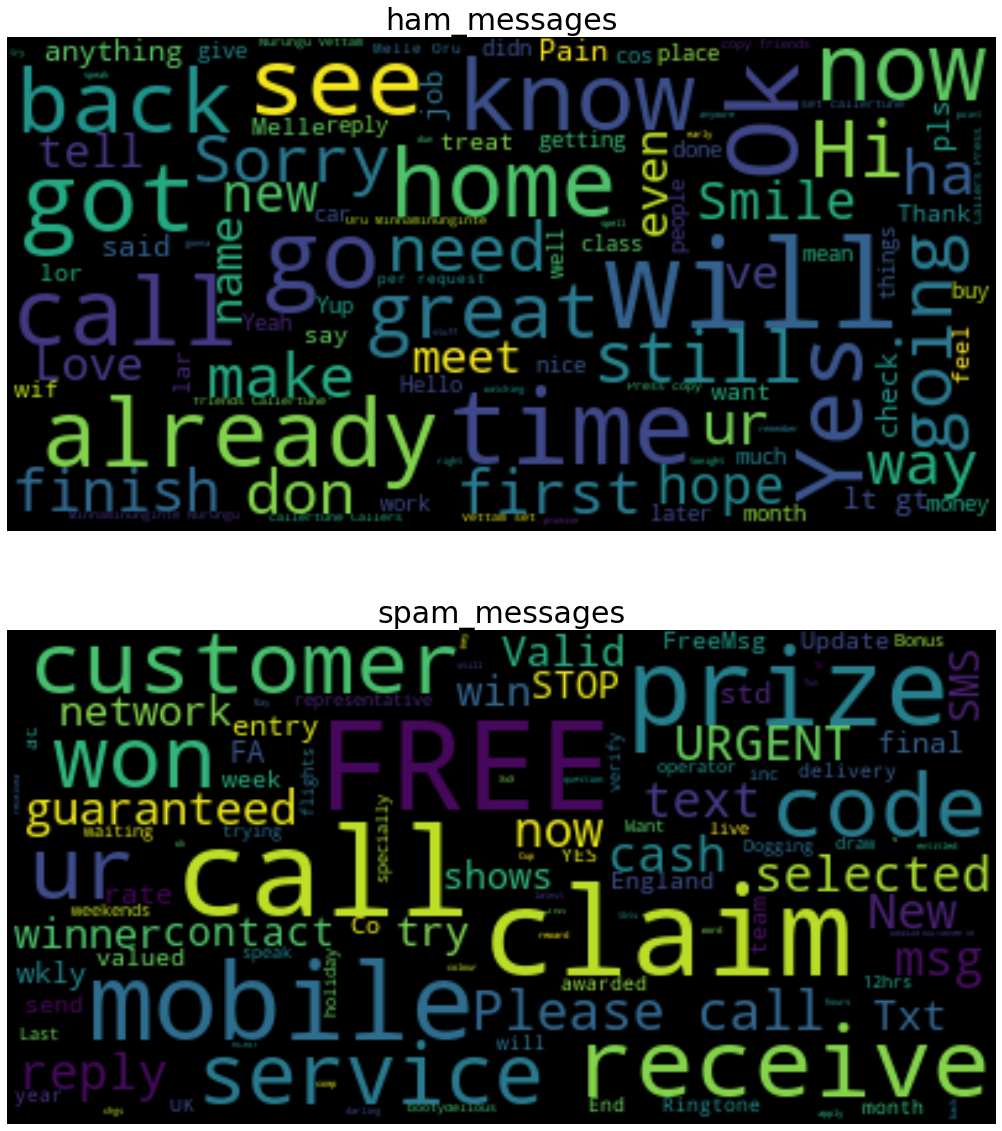

In [10]:
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
# Start with one message:
df_ham=df[df['label'] == 'ham']
df_spam=df[df['label']=='spam']

message_all=" ".join(message for message in df.Message)
message_ham=" ".join(message for message in df_ham.Message)
message_spam=" ".join(message for message in df_spam.Message)


# Create and generate a word cloud image:
fig, ax = plt.subplots(2, 1, figsize  = (20,20))
wordcloud_ham = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(message_ham)
wordcloud_spam = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(message_spam)

# Display the generated image:
ax[0].imshow(wordcloud_ham, interpolation='bilinear')
ax[0].set_title('ham_messages', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_spam, interpolation='bilinear')
ax[1].set_title('spam_messages',fontsize=30)
ax[1].axis('off')

From word cloud it can be visualize easily that while ham messages contains simple conversation words like 'love','sorry','already','yes'.'ok'etc,spam messages mostly contains some exciting words like 'prizes','selected','won','claim'etc which requires receiver's attention immediately.

In [11]:
data = df.replace(['ham','spam'],[0, 1]) 
data.head()

,Message,label
0,'Go until jurong point,0
1,'Ok lar... Joking wif u oni...',0
2,'Free entry in 2 a wkly comp to win FA Cup fin...,1
3,'U dun say so early hor... U c already then sa...,0
4,'Nah I don\'t think he goes to usf,0


In [24]:
# Import nltk packages and Punkt Tokenizer Models
import nltk
nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [25]:
#remove the punctuations and stopwords
import string
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [26]:
data['Message'] = data['Message'].apply(text_process)

In [50]:
data.head(10)

,Message,label
0,Go jurong point,0
1,Ok lar Joking wif u oni,0
2,Free entry 2 wkly comp win FA Cup final tkts 2...,1
3,U dun say early hor U c already say,0
4,Nah dont think goes usf,0
5,FreeMsg Hey darling 3 weeks word back Id like ...,1
6,Even brother like speak treat like aids patent,0
7,per request Melle Melle Oru Minnaminunginte Nu...,0
8,WINNER valued network customer selected receiv...,1
9,mobile 11 months U R entitled Update latest co...,1


In [29]:
text = pd.DataFrame(data['Message'])
label = pd.DataFrame(data['label'])
label

,label
0,0
1,0
2,1
3,0
4,0
...,...
195,0
196,0
197,0
198,0


# Converting words to vectors

In [30]:
## Counting how many times a word appears in the dataset

from collections import Counter

total_counts = Counter()
for i in range(len(text)):
    for word in text.values[i][0].split(" "):
        total_counts[word] += 1

print("Total words in data set: ", len(total_counts))

Total words in data set:  1028


In [31]:
# Sorting in decreasing order (Word with highest frequency appears first)
vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(vocab[:60])

['U', '2', 'Im', 'u', 'call', 'like', '‘', 'know', 'already', 'back', 'go', 'got', 'home', 'Yes', 'see', 'dont', 'still', 'Melle', 'v', 'way', 'ur', 'Please', 'get', 'Ok', 'receive', 'ok', 'prize', 'claim', 'Call', 'make', 'finish', 'time', 'Sorry', 'new', 'need', 'Smile', '£1000', 'Hi', 'speak', 'friends', 'customer', 'selected', 'R', 'tonight', 'name', 'going', 'try', 'ha', 'meet', 'Lol', 'car', 'K', 'reply', 'great', 'free', 'ltgt', 'check', 'said', 'day', 'job']


In [32]:
# Mapping from words to index

vocab_size = len(vocab)
word2idx = {}
#print vocab_size
for i, word in enumerate(vocab):
    word2idx[word] = i

In [33]:
# Text to Vector
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)

In [34]:
# Convert all titles to vectors
word_vectors = np.zeros((len(text), len(vocab)), dtype=np.int_)
for i, (_, text_) in enumerate(text.iterrows()):
    word_vectors[i] = text_to_vector(text_[0])

#Converting words to vectors using TFIDF Vectorizer

In [36]:
#convert the text data into vectors
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['Message'])
vectors.shape

(200, 899)

In [37]:
#features = word_vectors
features = vectors

#Splitting into training and test set

In [38]:
#split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.15, random_state=111)

## **Classifying using sklearn pre built classifiers**

In [39]:
#import sklearn packages for building classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [40]:
#initialize multiple classification models 
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

In [41]:
#create a dictionary of variables and models
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

In [42]:
#fit the data onto the models
def train(clf, features, targets):    
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [43]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [accuracy_score(y_test , pred)]))

#Predictions using TFIDF Vectorizer algorithm


In [44]:
pred_scores_word_vectors

[('SVC', [0.7666666666666667]),
 ('KN', [0.7333333333333333]),
 ('NB', [0.9]),
 ('DT', [0.7666666666666667]),
 ('LR', [0.7333333333333333]),
 ('RF', [0.7333333333333333])]

###Model predictions

In [45]:
#write functions to detect if the message is spam or not
def find(x):
    if x == 'spam':
        print ("Message is SPAM")##Model predictions
    else:
        print ("Message is NOT Spam")

In [53]:
newtext = ["mobile 11 months U R entitled Update latest co	"]
integers = vectorizer.transform(newtext)

In [54]:
x = mnb.predict(integers)
find(x)    

Message is NOT Spam


## Tokenization


In [13]:
word_list = []

max = len(df.Message)
for i in range (max):
  R1= df.Message[i]
  tokens = R1.split()
  #print(tokens)
  words = []
  
  for token in tokens:
    words.append(token.lower())
  word_list.append(words) 
print(len(word_list))
word_list[0:5]

200


[["'go", 'until', 'jurong', 'point'],
 ["'ok", 'lar...', 'joking', 'wif', 'u', "oni...'"],
 ["'free",
  'entry',
  'in',
  '2',
  'a',
  'wkly',
  'comp',
  'to',
  'win',
  'fa',
  'cup',
  'final',
  'tkts',
  '21st',
  'may',
  '2005.',
  'text',
  'fa',
  'to',
  '87121',
  'to',
  'receive',
  'entry',
  'question(std',
  'txt',
  "rate)t&c\\'s",
  'apply',
  "08452810075over18\\'s'"],
 ["'u",
  'dun',
  'say',
  'so',
  'early',
  'hor...',
  'u',
  'c',
  'already',
  'then',
  "say...'"],
 ["'nah", 'i', "don\\'t", 'think', 'he', 'goes', 'to', 'usf']]

# Lexicon approach

In [14]:
#Load the Lexicon file
from google.colab import files
uploaded=files.upload()

Saving AFINN-111.csv to AFINN-111.csv


In [15]:
#Read the Lexicon File
lex_file = open("AFINN-111.csv",encoding='cp1252')

In [17]:
lexicons = {}
records = lex_file.readlines()
for record in records:
    print(record) # line contains newline charecter
    print(record.rstrip('\n').split(",")) #to remove new line charecter
    lexicons[record.rstrip('\n').split(",")[0]] = int(record.rstrip('\n').split(",")[1])
print(lexicons)    


{}


In [18]:
#For each Message
#For each word in Message
#Get the word score (score is a numbe rif the word is in Lexicon, 0 if not)
#Add all the scores and find the ploarity
#Assume if the score is zero or Positive its Ham, in case of negative its a spam
strength = []
prediction = []
for message in df:
    score = 0
    for word in message:
        if word in (lexicons):
            score = score + lexicons[word]
    strength.append(score)
    if score >=  0:
        prediction.append('ham')
    else:
        prediction.append('spam')

In [19]:
df.head()

,Message,label
0,'Go until jurong point,ham
1,'Ok lar... Joking wif u oni...',ham
2,'Free entry in 2 a wkly comp to win FA Cup fin...,spam
3,'U dun say so early hor... U c already then sa...,ham
4,'Nah I don\'t think he goes to usf,ham


In [20]:
df['strength'] = strength
df['prediction']= prediction

ValueError: ignored

In [ ]:
#For each word in text
#Get the word score (score is a number if the word is in Lexicon, 0 if not)
#Add all the scores and find the ploarity
strength = []
for text in word_list:
    score = 0
    for word in text:
        if word in (lexicons):
            score = int(score + lexicons[word])
    strength.append(score)
strength[1]

0

In [ ]:
df['strength'] = strength
df.tail()

,Message,label,strength
195,'How are you doing? Hope you\'ve settled in fo...,ham,0
196,'Gud mrng dear hav a nice day',ham,0
197,'Did u got that persons story',ham,0
198,'is your hamster dead? Hey so tmr i meet you a...,ham,0
199,'Hi its Kate how is your evening? I hope i can...,ham,0


# Feature Engineering

### Now I will do feature engineering and use BAG OF WORDS Technique to work with Naive bayes model

In [ ]:
df_ham['length']=df['Message'].apply(len)
df_ham.head()

In [ ]:
df_ham['length'].plot.hist(bins=50)

In [ ]:
df_spam['length']=df['Message'].apply(len)
df_spam.head()

In [ ]:
df_spam['length'].plot.hist(bins=50)

### It can be obsereved that SPAM messages generally have more characters

##Creating Labels and Features to apply ML models

In [ ]:
#creating label & features
x = df.iloc[:, 0]
x.head()
y = df.iloc[:, 1]
y.head()


# Data preprocessing

In [ ]:
import string
string.punctuation

In [ ]:
df.info()

#Tokenization & Cleaning data

In [ ]:
nopunc=[c for c in df['Message'] if c not in string.punctuation]
nopunc=''.join(nopunc)
nopunc.split()
clean_message=[word for word in nopunc.split() if word.lower() not in stopwords.words('english')]


In [ ]:
def text_process( Message):
    nopunc=[char for char in  Message if char not in string.punctuation]
    
    nopunc=''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english') ]
df['Message'].head(5).apply(text_process)

In [ ]:
#Bag of word model
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer=CountVectorizer(analyzer=text_process).fit(df['Message'])
messages_bow=bow_transformer.transform( df['Message'])
print('Shape of Sparse Matrix: ',messages_bow.shape)


In [ ]:
#TF IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer().fit(messages_bow)
df_tfidf=tfidf_transformer.transform(messages_bow)
df_tfidf

In [ ]:
# Train Test Split

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.35, random_state = 0)

In [ ]:
#Naive bayes model
from sklearn.naive_bayes import MultinomialNB
spam_detect_model=MultinomialNB().fit(df_tfidf,df['label'])

In [ ]:
#Instead of doing everything again, in which we have to get rid of punctuation, get rid of stop words, 
# And then do tf and idf we would use Pipelines option
from sklearn.pipeline import Pipeline

pipeline=Pipeline([
        ('bow',CountVectorizer(analyzer=text_process)),
        ('tfidf',TfidfTransformer()),
        ('classifier',MultinomialNB())
    ])
pipeline.fit(x_train,y_train)

In [ ]:
predicted=pipeline.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predicted),confusion_matrix(y_test,predicted))


###Although accuracy is high here & even f1-score is good for ham(1) messages but for spam(2)messages  recall &f1-score is not so good.So I need to build a better model with some other classification model or may be need to tune the model  a little bit.
###it might be  due to less number of data for spam messages like here only 10 samples for spam messages are avialable in my test data.So it can be corrected with some other sampling technique like undersampling or oversampling technique as well.